<a href="https://colab.research.google.com/github/LCaravaggio/ClaseTimeSeries/blob/main/Ejercicio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 3

La primera parte es toda igual.

Primero importamos todas las librerías necesarias. 

In [24]:
from google.colab import drive
import json

import requests
from requests.auth import HTTPBasicAuth

import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels

Por una cuestión de seguridad, tenemos la clave de la API guardada en el drive, así que accedemos a la misma.

In [2]:
drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/alphacast.json", 'r') as f:
    api_token= json.load(f)

Mounted at /content/drive


In [3]:
# Definir user key para la API
user_key = api_token["key"]

Para ir incorporando también opciones de uso de la API, podemos traer solo una columna esta vez. En este caso nos interesa solo el Nivel General del IPC. 

In [12]:
# IPC
select='68119'
ipc = requests.get('https://api.alphacast.io/datasets/5864/data?apiKey='+user_key+'&%24select='+select+'&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('ipc.csv','wb').write(ipc.content)
ipc = pd.read_csv('ipc.csv',delimiter = ',')

Ahora traemos M0, e incorporamos el corte de fecha directamente en la llamada. 

In [59]:
# M0
select='8092'
data='6054'
fecha='2015-12-01'
m0 = requests.get('https://api.alphacast.io/datasets/'+data+'/data?apiKey='+user_key+'&%24select='+select+'&%24filter=%27Date%27+ge+'+fecha+'T03%3A00%3A00.000Z&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('m0.csv','wb').write(m0.content)
m0 = pd.read_csv('m0.csv',delimiter = ',')

Eliminamos la última observación vacía, y graficamos

In [140]:
m0=m0[:-1]

In [142]:
M0=m0['Agregados monetarios, saldos afin de mes, en miles de pesos - Base monetaria (M0) - Circulación monetaria - En entidades financieras']
IPC=ipc['Nivel general']

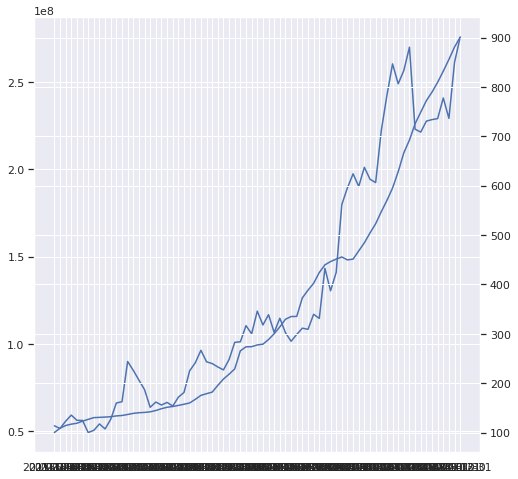

In [143]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.plot(m0['Date'], M0)
ax2.plot(m0['Date'], IPC);

Vamos a correr ahora un test de Granger para testear la causalidad. 

In [158]:
date= ipc['Date']

d = {'Date': date, 'IPC': IPC, 'M0': M0}
df = pd.DataFrame(data=d)
df

,Date,IPC,M0
0,2015-12-01,100.000000,53235893.0
1,2016-01-01,108.787179,51701928.0
2,2016-02-01,114.170884,55855268.0
3,2016-03-01,117.000648,59356244.0
4,2016-04-01,118.812576,56391613.0
...,...,...,...
68,2021-08-01,809.371687,228923225.0
69,2021-09-01,831.993670,240717770.0
70,2021-10-01,855.682472,229054188.0
71,2021-11-01,880.888646,261125328.0


In [159]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Comprueba la causalidad de Granger de todas las combinaciones posibles de la serie temporal.
     Las filas son la variable de respuesta, las columnas son predictores. Los valores en la tabla
     son los valores P. P-Valores menores que el nivel de significancia (0.05), implica
     la hipótesis nula de que los coeficientes de los valores pasados correspondientes es
     cero, es decir, la X no hace que Y pueda ser rechazada.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = ['IPC', 'M0'])

,IPC_x,M0_x
IPC_y,1.0,0.0175
M0_y,0.0,1.0000


La fila son la Respuesta (Y) y las columnas son la serie predictora (X). Por ejemplo, si toma el valor 0.0175 en (fila 1, columna 2), se refiere al valor p de M0 que causa IPC. Mientras que el 0,000 en (fila 2, columna 1) se refiere al valor p de M0 que causa IPC. Entonces, ¿cómo interpretar los valores de p? Si un valor p dado es < nivel de significancia (0.05), entonces, la serie X correspondiente (columna) causa la Y (fila). Por ejemplo, el valor P de 0.0175 en (fila 1, columna 2) representa el valor p de la prueba de causalidad de Granger para M0 que causa IPC, que es menor que el nivel de significación de 0,05. Entonces, se puede rechazar la hipótesis nula y concluir que M0 causa IPC. 

La prueba de cointegración ayuda a establecer la presencia de una conexión estadísticamente significativa entre dos o más series de tiempo. 

El orden de integración (d) es el número de diferenciaciones requeridas para hacer que una serie de tiempo no estacionaria sea estacionaria. 

Ahora, cuando tenés dos o más series de tiempo, y existe una combinación lineal de ellas que tiene un orden de integración (d) menor que el de la serie individual, entonces se dice que la colección de series está cointegrada. Cuando dos o más series de tiempo están cointegradas, significa que tienen una relación estadísticamente significativa a largo plazo. Esta es la premisa básica en la que se basan los modelos de vectores autorregresivos (VAR). Por lo tanto, es bastante común implementar la prueba de cointegración antes de comenzar a construir modelos VAR. 

Soren Johanssen en su artículo (1991) ideó un procedimiento para implementar la prueba de cointegración. Es bastante sencillo de implementar en los modelos de estadísticas de Python, como puede ver a continuación.

In [163]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def adjust(val, length= 6): return str(val).ljust(length)

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]  

    # Resultado
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(pd.DataFrame({'IPC': IPC, 'M0': M0}))

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
IPC    ::  19.75     > 12.3212   =>   True
M0     ::  5.11      > 4.1296    =>   True


Ahora bien, evidentemente las series son no estacionarias, por lo que corresponderá hacerlas estacionarias antes de correr el modelo VAR. 

In [175]:
d = {'IPC': IPC, 'M0': M0}
df = pd.DataFrame(data=d)
df1=df.diff().dropna()
df2=df1.diff().dropna()

In [179]:
from statsmodels.tsa.stattools import adfuller
res=adfuller(df['IPC'])
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')
for key, value in res[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.537760
p-value: 1.000000
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589


No alcanza ni siquiera diferenciando una vez las series para volverlas estacionarias. 

In [181]:
from statsmodels.tsa.api import VAR

model = VAR(df2)
x = model.select_order(maxlags=12)
x.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,37.98,38.05,3.119e+16,38.01
1,37.60,37.82,2.145e+16,37.69
2,37.43*,37.79*,1.812e+16*,37.57*
3,37.50,37.99,1.940e+16,37.69
4,37.59,38.23,2.133e+16,37.84
5,37.69,38.46,2.355e+16,37.99
6,37.72,38.64,2.446e+16,38.08
7,37.65,38.71,2.300e+16,38.06
8,37.76,38.96,2.603e+16,38.23
9,37.87,39.21,2.935e+16,38.39


In [182]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 14, Feb, 2022
Time:                     16:07:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    37.4480
Nobs:                     69.0000    HQIC:                   37.2527
Log likelihood:          -1466.60    FPE:                1.32759e+16
AIC:                      37.1242    Det(Omega_mle):     1.15425e+16
--------------------------------------------------------------------
Results for equation IPC
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.453751         0.935489            0.485           0.628
L1.IPC        -0.447847         0.117532           -3.810           0.000
L1.M0         -0.000000         0.000000           -0.371           0.711
L2.IPC        -0

In [183]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

IPC    : 2.03
M0     : 2.13
